In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import trange
import glob,os
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

from tqdm.keras import TqdmCallback
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3999053871221414419,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13048342869510409129
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8502083960491909600
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 23237492736
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10146045750009224153
 physical_device_desc: "device: 0, name: GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6"]

In [2]:
for f in glob.glob('images/glow3/*.png'):
    os.remove(f)

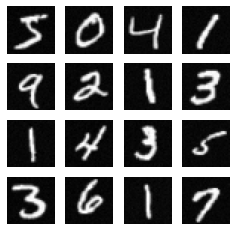

In [3]:
(train_images, train_labels), (validate_images,validate_labels) = tf.keras.datasets.mnist.load_data()
train_images =train_images.reshape([-1,28,28,1]).astype('float32')
train_images = tf.image.resize(train_images,[32,32])
images_shape = train_images.shape
train_images = train_images/255.0
train_images = train_images + tf.random.normal(images_shape,mean=0.0,stddev=1e-2)
fig = plt.figure(figsize=(4,4))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(train_images[i], cmap = 'gray')
    plt.axis('off')
    
BUFFER_SIZE = 1000
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [4]:
tfk = tf.keras
tfkl = tfk.layers
import functools

class GlowDefaultNetwork(tfk.Sequential):
  """Default network for the glow bijector.
  This builds a 3 layer convolutional network, with relu activation functions
  and he_normal initializer. The first and third layers have default kernel
  shape of 3, and the second layer is a 1x1 convolution. This is the setup
  in the public version of Glow.
  The output of the convolutional network defines the components of an Affine
  transformation (i.e. y = m * x + b), where m, x, and b are all tensors of
  the same shape, and * indicates elementwise multiplication.
  """

  def __init__(self, input_shape, num_hidden=32, kernel_shape=3):
    """Default network for glow bijector."""
    # Default is scale and shift, so 2c outputs.
    this_nchan = input_shape[-1] * 2
    conv = functools.partial(
        tfkl.Conv2D,
        padding='same',
        kernel_initializer=tf.initializers.he_normal(),
        activation='relu')
    conv_last = functools.partial(
        tfkl.Conv2D,
        padding='same',
        kernel_initializer=tf.initializers.zeros(),
        bias_initializer=tf.initializers.zeros())
    super(GlowDefaultNetwork, self).__init__([
        tfkl.Input(shape=input_shape),
        conv(num_hidden, kernel_shape),
        conv(num_hidden, 1),
        conv_last(this_nchan, kernel_shape)
    ])
    
output_dim = 32*32
bijectors = []
glow_bijector = tfp.bijectors.Glow(
                output_shape=[32,32,1],
                num_glow_blocks = 3,
                num_steps_per_block=8,
                use_actnorm = True,
                coupling_bijector_fn=GlowDefaultNetwork,
                exit_bijector_fn=tfb.GlowDefaultExitNetwork)

ref_dist = tfd.MultivariateNormalDiag(loc=tf.zeros(output_dim,tf.float32),
                                      scale_diag = tf.ones(output_dim,tf.float32))
flow = tfd.TransformedDistribution(distribution=ref_dist,
                                   bijector=glow_bijector)

In [5]:
@tf.function
def train_step(target_sample):
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(flow.log_prob(target_sample))
    gradients = tape.gradient(loss,flow.trainable_variables)
    optimizer.apply_gradients(zip(gradients,flow.trainable_variables))
    return loss

@tf.function
def sample(N):
    return tf.reshape(flow.sample(N),[-1,32,32])

def save_samples(epoch):
    images = sample(16)
    fig = plt.figure(figsize=(4,4))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(images[i], cmap = 'gray')
        plt.axis('off')
    plt.suptitle('epoch: %03d'%(epoch))
    plt.savefig('images/glow3/image_at_epoch_{:04d}.png'.format(epoch))
    plt.close(fig)

def train(dataset,num_epochs):
        t = trange(num_epochs)
        for epoch in t:
            for batch in dataset:
                loss = train_step(batch)
                t.set_description("loss: %0.3f " % loss.numpy())
                t.refresh()
                loss_history.append(loss.numpy())
            save_samples(epoch)
        return None

In [6]:
loss_history = []
LR = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
train(train_dataset,200)

loss: -2876.239 : 100%|██████████| 200/200 [1:21:07<00:00, 24.34s/it]


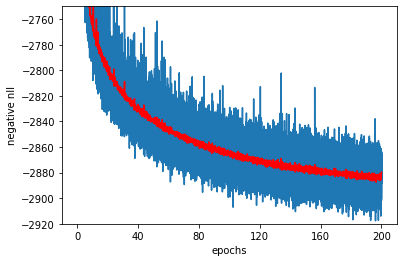

In [63]:
from scipy.ndimage.filters import gaussian_filter1d
plt.plot(loss_history)
ysmoothed = gaussian_filter1d(loss_history, sigma=30)
plt.plot(ysmoothed,color='red')
plt.ylim(-2920,-2750)
x = list(range(0,len(loss_history),int((60000/128)*40)))
labels = list(range(0,240,40))
plt.xticks(x, labels)
plt.xlabel('epochs')
plt.ylabel('negative nll')
plt.savefig('images/glow/loss_plot.png')

In [8]:
# In future probability better to just chain bijectors from
# f and f_hat, with standard normal as base distribution for
# the TransformedDistribution
class ComposedFlow():
    def __init__(self,f,f_hat,x2_obs,output_dim,opt):
        self.f = f
        self.f_hat = f_hat
        # x2_obs must be list of rank 1
        assert tf.rank(x2_obs) == 1
        self.x2_obs = x2_obs
        self.x2_dim = len(x2_obs)
        self.output_dim = output_dim
        assert (self.output_dim - self.x2_dim) > 0
        self.x1_dim = self.output_dim - self.x2_dim
        self.opt = opt
        # Don't give user for base distribution since standard normal is assumed
        # for objective function
        self.NormalDist = tfd.MultivariateNormalDiag(loc=tf.zeros(self.output_dim), 
                                                     scale_diag=tf.ones(self.output_dim))

    @tf.function
    def train_step(self,batch_size,sigma):
        z0 = self.NormalDist.sample(batch_size)
        with tf.GradientTape() as tape:
            z1 = self.f_hat(z0)
            loss = tf.reduce_mean(self.f_hat.log_prob(z1) - self.NormalDist.log_prob(z1)
                   + 1.0/(2.0*sigma**2)*tf.norm(self.f(z1)[:,self.x1_dim:]-self.x2_obs,axis=-1)**2) 
        gradients = tape.gradient(loss, self.f_hat.trainable_variables)
        self.opt.apply_gradients(zip(gradients, self.f_hat.trainable_variables))
        return loss
    
    def train_pre_conditioner(self,epochs,batch_size,sigma):
        t = trange(epochs)
        loss_history = []
        for epoch in t:
            loss = self.train_step(batch_size,sigma)
            t.set_description("loss: %0.3f " % loss.numpy())
            t.refresh()
            loss_history.append(loss.numpy())
        return loss_history
    
    @tf.function
    def sample(self,N):
        return self.f(self.f_hat.sample(N))

In [26]:
class GLOW(tf.keras.Model):
    
    def __init__(self,flow):
        super(GLOW,self).__init__()
        self.flow = flow
        self.vars = flow.trainable_variables
    @tf.function
    def call(self, inputs):
        return self.flow.bijector.forward(inputs)
    
    @tf.function
    def inverse(self,inputs):
        return self.flow.bijector.inverse(inputs)
    
    @tf.function
    def sample(self,N):
        return self.flow.sample(N)
    
    @tf.function
    def nll(self,inputs):
        return -tf.reduce_mean(flow.log_prob(target_sample))

    def compile(self,optimizer):
        super(GLOW, self).compile()
        self.optimizer = optimizer
        self.loss_fn = self.nll

Model: "glow_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 126,612
Trainable params: 126,612
Non-trainable params: 0
_________________________________________________________________


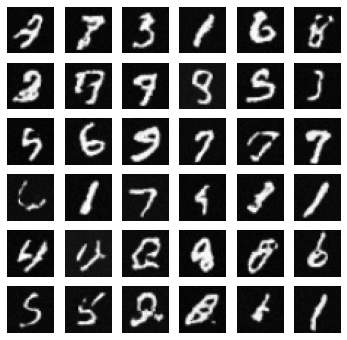

<Figure size 432x288 with 0 Axes>

In [64]:
glow = GLOW(flow)
glow(tf.random.normal([1,output_dim]))
glow.summary()
glow.save_weights('models/glow/')

def plot_samples(model):
    images = model.sample(36)
    fig = plt.figure(figsize=(6,6))
    for i in range(36):
        plt.subplot(6,6,i+1)
        plt.imshow(images[i], cmap = 'gray')
        plt.axis('off')
    plt.savefig('images/glow/glow_samples.png')
    plt.pause(0.5)
    
glow_bijector2 = tfp.bijectors.Glow(
                output_shape=[32,32,1],
                num_glow_blocks = 3,
                num_steps_per_block=8,
                use_actnorm = True,
                coupling_bijector_fn=GlowDefaultNetwork,
                exit_bijector_fn=tfb.GlowDefaultExitNetwork)

ref_dist2 = tfd.MultivariateNormalDiag(loc=tf.zeros(output_dim,tf.float32),
                                      scale_diag = tf.ones(output_dim,tf.float32))
flow2 = tfd.TransformedDistribution(distribution=ref_dist2,
                                   bijector=glow_bijector2)
glow_new = GLOW(flow2)
glow_new.load_weights('models/glow/')
plot_samples(glow_new)

In [28]:
def save_optimizer_state(optimizer, save_path, save_name):
    '''
    Save keras.optimizers object state.

    Arguments:
    optimizer --- Optimizer object.
    save_path --- Path to save location.
    save_name --- Name of the .npy file to be created.

    '''

    # Create folder if it does not exists
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    # save weights
    np.save(os.path.join(save_path, save_name), optimizer.get_weights())

    return

def load_optimizer_state(optimizer, load_path, load_name, model_train_vars):
    '''
    Loads keras.optimizers object state.

    Arguments:
    optimizer --- Optimizer object to be loaded.
    load_path --- Path to save location.
    load_name --- Name of the .npy file to be read.
    model_train_vars --- List of model variables (obtained using Model.trainable_variables)

    '''

    # Load optimizer weights
    opt_weights = np.load(os.path.join(load_path, load_name)+'.npy', allow_pickle=True)

    # dummy zero gradients
    zero_grads = [tf.zeros_like(w) for w in model_train_vars]
    # save current state of variables
    saved_vars = [tf.identity(w) for w in model_train_vars]

    # Apply gradients which don't do nothing with Adam
    optimizer.apply_gradients(zip(zero_grads, model_train_vars))

    # Reload variables
    [x.assign(y) for x,y in zip(model_train_vars, saved_vars)]

    # Set the weights of the optimizer
    optimizer.set_weights(opt_weights)


    return

In [29]:
save_path = 'models/glow/'
save_name ='glow_optimizer'
save_optimizer_state(optimizer,save_path,save_name)